## < 기본 모듈 호출 및 데이터 로드>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager as fm
import matplotlib
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

In [2]:
import os
path = 'path'
os.chdir(path)

In [3]:
news = pd.read_csv('2018sec4.csv')
print(len(news))
news.head()

52009


,title,agency,date
0,"올해 MWC도 '5G가 대세'…삼성, 갤워치 새 OS 공개",매일경제,201812
1,"KT, 5G 네트워크 전력절감기술 소개",헤럴드경제,201812
2,"루트메트릭스 ""한국 5G 세계 최고 모범사례""",전자신문,201812
3,삼성·네이버도 자체 5G망 까는 길 열렸다…정부가 주파수 할당,중앙일보,201812
4,"[비상장기업 탐방]콘텔라, 스몰셀 기술력으로 5G 시장 신흥 강자로",전자신문,201812


In [4]:
news = news[['title', 'agency']]
news.head()

,title,agency
0,"올해 MWC도 '5G가 대세'…삼성, 갤워치 새 OS 공개",매일경제
1,"KT, 5G 네트워크 전력절감기술 소개",헤럴드경제
2,"루트메트릭스 ""한국 5G 세계 최고 모범사례""",전자신문
3,삼성·네이버도 자체 5G망 까는 길 열렸다…정부가 주파수 할당,중앙일보
4,"[비상장기업 탐방]콘텔라, 스몰셀 기술력으로 5G 시장 신흥 강자로",전자신문


In [5]:
# 중복제외 갯수 확인

print(news['title'].nunique())
print(news['agency'].nunique())

news = news.drop_duplicates(subset = ['title'], ignore_index = True)
print('총 기사 수 :', len(news))

4016
330
총 기사 수 : 4016


In [6]:
# 한국어 폰트 (코랩에서 하면 잘 안되서 폰트를 따로 올려줘야함)
# 주피터 사용가능
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'NanumGothic'

<AxesSubplot:xlabel='agency', ylabel='count'>

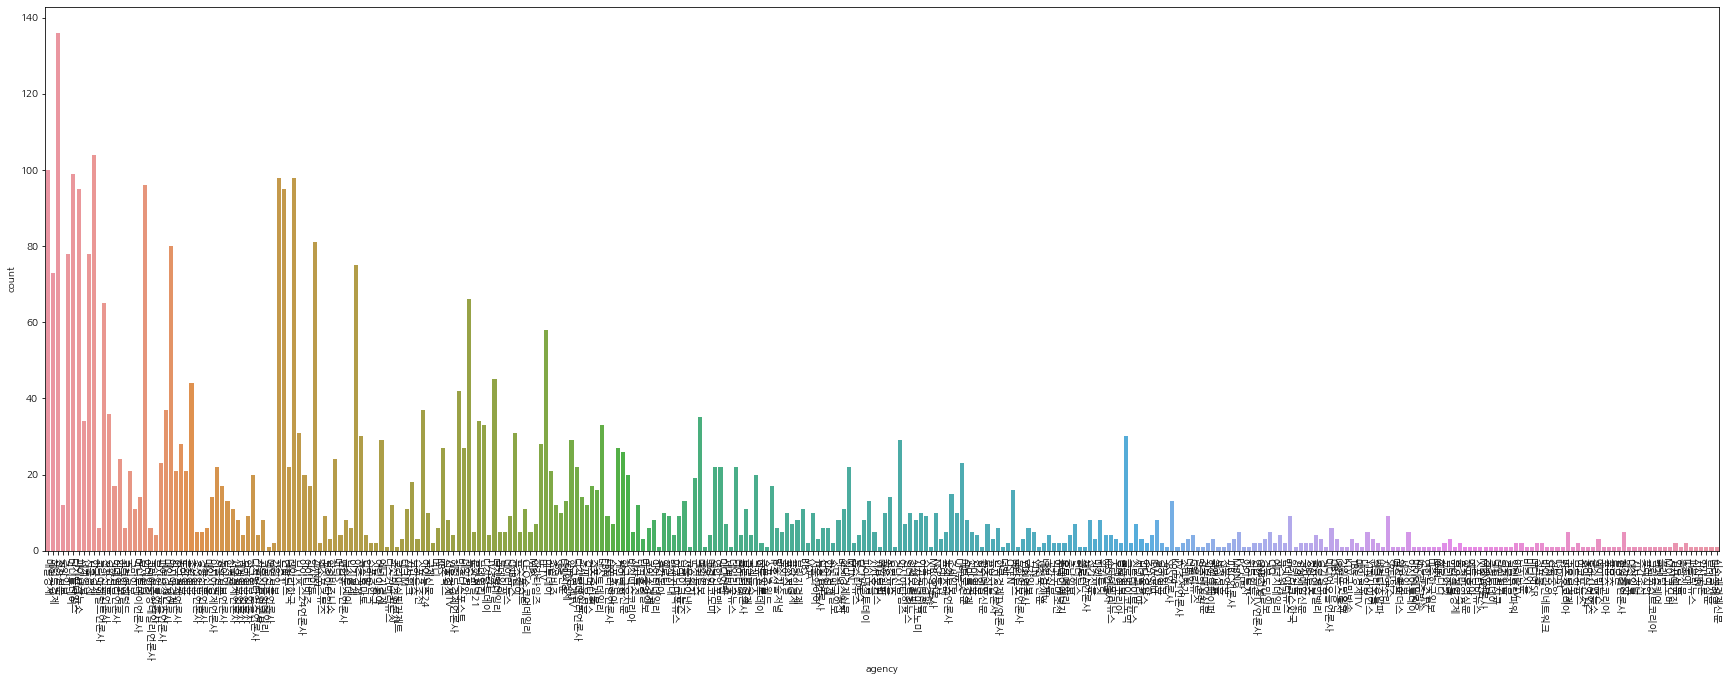

In [7]:
# agency 별 빈도 가시화
fig, axe = plt.subplots(ncols = 1)
fig.set_size_inches(30,10)
plt.xticks(rotation = -90)
sns.countplot(news['agency'])

In [8]:
# 가시화한게 잘 안보여서 기사 수 많은 상위 10개 agency 확인
sort = news['agency'].value_counts(sort = True, ascending = False)
sort.head(10)

전자신문      136
한국경제      104
매일경제      100
디지털타임스     99
뉴시스        98
뉴스1        98
이데일리       96
파이낸셜뉴스     95
연합뉴스       95
ZDNet      81
Name: agency, dtype: int64

### 데이터 정제

#### 일반 전처리(정제화-토큰화-정규화)

In [11]:
# 정제화 코드

from konlpy.tag import Okt
with open("korean_stopwords.txt", encoding='utf-8') as files: 
    stopwords = files.readlines()

okt = Okt()

other_stopwords = ['내용', '누설', '아래', '해당', '설명', '표기','모든', '매우', '가장',
                    '요소', '틀', '경우', '때문', '모습', '정도', '이후', '사실', '생각', 
                    '이름', '년월', 'M', 'A', 'AI', '5', 'G', '+', '있는', '의','가','이','은','들','는','좀',
                   '잘','걍','과','도','를','으로','자','에','와','한','하다', 'LG', '5G', 'SK', '유플러스', 'SKT','KT', '텔레콤'
                    '삼성전기', '삼성','전기','화웨이']

for stopword in other_stopwords:
    stopwords.append(stopword)

clean_sent = []
for title in news['title']:
    clean = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\''‘·|\(\)\[\]\<\>`\'…\"\“’]', '', title)
    clean = re.sub('[^ A-Za-z0-9가-힣]','', title)
    clean_sent.append(clean)

word = []
for sentences in clean_sent:
    s = []
    # 정규화
    s = okt.normalize(sentences)
    # 토큰화
    s = okt.morphs(sentences, stem = True) # stem 옵션은 일정 수준 정규화(어간추출)를 수행해줌
    # 불용어 제거
    s = [word for word in s if not word in stopwords]
    # 한글자 단어 제거
    s = [a for a in s if len(a) > 1]
    word.append(s)


In [12]:
print(clean_sent[:3])

['올해 MWC도 5G가 대세삼성 갤워치 새 OS 공개', 'KT 5G 네트워크 전력절감기술 소개', '루트메트릭스 한국 5G 세계 최고 모범사례']


In [13]:
print(word[:3])

[['올해', 'MWC', '가다', '대세', '개다', '워치', 'OS', '공개'], ['네트워크', '전력', '절감', '기술', '소개'], ['루트', '트릭', '한국', '세계', '최고', '모범', '사례']]


## [1] 문서-단어 매트릭스 유사도 분석
주요 단어 구분 시기 파악
TF-IDF 기반 문서-단어 매트릭스

### TF-IDF & 코사인 유사도

In [14]:
# TF-IDF
# input데이터로 리스트 형태 데이터 필요
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(clean_sent)

print(tfidf_matrix.shape)

(4016, 9043)


## [2] N-GRAM 검증
주요 단어, 시기별 주요 단어 검증

### N-GRAM 검증 

In [16]:
uni_vectorizer = CountVectorizer(ngram_range = (1, 1))
transformer = TfidfTransformer()
uni_tfidf_bf = uni_vectorizer.fit_transform(clean_sent)
uni_tfidf = transformer.fit_transform(uni_tfidf_bf)

In [17]:
df_uni_idf = pd.DataFrame(transformer.idf_, index=uni_vectorizer.get_feature_names(),columns=["idf_weights"])
df_uni_idf.sort_values(by=['idf_weights']).head(20)

,idf_weights
5g,1.641953
kt,3.561718
lg유플러스,3.737609
sk텔레콤,3.882190
시대,3.909219
skt,3.936998
화웨이,4.061849
세계,4.122141
lgu,4.139235
하현회,4.385636


In [15]:
bi_vectorizer = CountVectorizer(ngram_range = (2, 2))
transformer = TfidfTransformer()
bi_tfidf_bf = bi_vectorizer.fit_transform(clean_sent)
bi_tfidf = transformer.fit_transform(bi_tfidf_bf)

In [16]:
df_bi_idf = pd.DataFrame(transformer.idf_, index=bi_vectorizer.get_feature_names(),columns=["idf_weights"])
df_bi_idf.sort_values(by=['idf_weights']).head(20)

,idf_weights
5g 시대,4.229386
sk텔레콤 5g,4.809654
skt 5g,4.832383
최초 5g,4.832383
lg유플러스 5g,4.867474
kt 5g,4.867474
세계 최초,4.941582
5g 스마트폰,5.078783
5g 상용화,5.272939
lgu 5g,5.309307


In [17]:
bi_tf_idf_vector=transformer.transform(bi_tfidf_bf)
bi_feature_names = bi_vectorizer.get_feature_names()
bi_first_document_vector=bi_tf_idf_vector[1]
bi_df_tfidf = pd.DataFrame(bi_first_document_vector.T.todense(), index=bi_feature_names, columns=["tfidf"])
bi_df_tfidf.sort_values(by=["tfidf"],ascending=False).head(20)

,tfidf
네트워크 전력절감기술,0.591686
전력절감기술 소개,0.591686
5g 네트워크,0.433361
kt 5g,0.334685
안보 우려,0.000000
안보 묶음,0.000000
안방선 360도,0.000000
안목으로 5g엔터,0.000000
안리쓰와 퀄컴,0.000000
안리쓰pctest 파트너십,0.000000


## [3] 토픽모델링
LDA이용 / Perplexity 평가

### LDA 시각화 및 최적의 토픽수 선정

In [18]:
from gensim import corpora
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel

id2word = corpora.Dictionary(word) # 정수 인코딩과 빈도수 생성
id2word.filter_extremes(no_below=20) # 출현빈도가 작거나 자주 등장하는 단어는 제거
corpus = [id2word.doc2bow(text) for text in word]
print(corpus[1])

# 정수인코딩이 1로된 단어가 1번 등장했다는 말

[(4, 1), (5, 1)]


In [19]:
# 단어가 정수 인코딩 되기 전에 어떤 단어였는지 확인 -> dictionary를 통해 확인 가능
print(id2word[4])

# 총 학습된 단어의 개수를 확인
len(id2word)

기술


285

In [20]:
# 단어코퍼스에 tfidf 적용

tf_idf = models.TfidfModel(corpus)
corpus_tfidf = tf_idf[corpus]

from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.5277852715012319),
 (1, 0.5200730904800247),
 (2, 0.4185405174605785),
 (3, 0.525157617281477)]


In [23]:
# corpus_tfidf 사용시에 사용
# 토픽별 coherence values 출력 함수

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=num_topics, id2word = dictionary, passes=2, workers=4, random_state=1) # random_state를 사용시 고정
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

In [24]:
# model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus_tfidf, texts=word, limit=10, start=2, step=1)

In [25]:
# # 최적의 토픽수

# limit=11; start=2; step=1;
# x = range(start, limit, step)
# topic_num = 0
# count = 0
# max_coherence = 0

# for m, cv in zip(x, coherence_values):
#     print("Num Topics =", m, " has Coherence Value of", cv)
#     coherence = cv
#     if coherence >= max_coherence:
#         max_coherence = coherence
#         topic_num = m
#         model_list_num = count   
#     count = count+1

Num Topics = 2  has Coherence Value of 0.4052584775439815
Num Topics = 3  has Coherence Value of 0.4793966206589113
Num Topics = 4  has Coherence Value of 0.4710641350644814
Num Topics = 5  has Coherence Value of 0.43326525794800375
Num Topics = 6  has Coherence Value of 0.45931379489389057
Num Topics = 7  has Coherence Value of 0.462815777725938
Num Topics = 8  has Coherence Value of 0.45712445741313124
Num Topics = 9  has Coherence Value of 0.4424411079034094


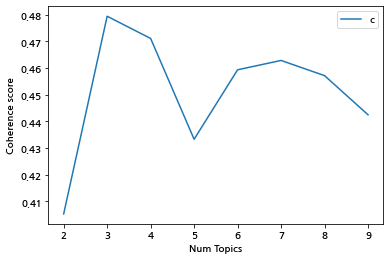

In [26]:
coherence_values=[]
for i in range(2,10):
    ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary)
    coherence_model_lda=CoherenceModel(model=ldamodel, texts = word, dictionary=dictionary, topn=10)
    coherence_lda=coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)
    
x=range(2,10)
plt.plot(x, coherence_values)
plt.xlabel("number of topics")
plt.ylabel("coherence score")
plt.show()

In [28]:
#최적의 모델 할당
optimal_model = model_list[1]

In [29]:
model_topics = optimal_model.show_topics(formatted=False)
#pprint(optimal_model.print_topics(num_words=10))
model_topics

[(0,
  [('전자', 0.020860689),
   ('기술', 0.018154684),
   ('자율', 0.016313337),
   ('시대', 0.013627095),
   ('내년', 0.012997387),
   ('텔레콤', 0.012355433),
   ('되다', 0.011804641),
   ('서비스', 0.011675585),
   ('투자', 0.01143004),
   ('행차', 0.009949274)]),
 (1,
  [('시대', 0.027997892),
   ('세계', 0.023956625),
   ('이통', 0.022520615),
   ('최초', 0.0155363735),
   ('내년', 0.01227389),
   ('개막', 0.012104362),
   ('사업', 0.012015644),
   ('스마트폰', 0.011600149),
   ('CES', 0.010940278),
   ('2019', 0.010683995)]),
 (2,
  [('텔레콤', 0.020689355),
   ('상용', 0.017551295),
   ('로봇', 0.016564187),
   ('통신', 0.016382322),
   ('공개', 0.016125698),
   ('테스트', 0.015386419),
   ('스마트', 0.015139626),
   ('개발', 0.014227878),
   ('LGU', 0.013652956),
   ('성공', 0.012636061)])]

In [30]:
#Compute model perplexity and coherence score
#compute perplexity
print('\nPerplexity: ', optimal_model.log_perplexity(corpus_tfidf))

#compute coherence score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=word, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score (c_v): ', coherence_lda)

coherence_model_lda = CoherenceModel(model=optimal_model, texts=word, dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score (u_mass): ', coherence_lda)

# u-mass는 0에 가까울수록 완벽한 일관성을 가짐
# c_v는 0-1사이로 0.55정도면 준수히다고 판단?
# https://joyhong.tistory.com/138


Perplexity:  -6.061626576360843

Coherence Score (c_v):  0.4793966206589113

Coherence Score (u_mass):  -10.344651426681631


In [31]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus_tfidf, id2word)
pyLDAvis.display(vis)

In [32]:
#문서별 토픽을 대표하는 확률(Perc_Contribution)을 계산하기 위한 함수
#기사하나를 하나의 문서로 생각
#여기서 맨처음에 lda학습한 model을 쓸지, 최적의 model을 쓸지만 고민?

def document_topics_probability(ldamodel=optimal_model, corpus=corpus, texts=word):

    document_topics_df = pd.DataFrame()

    for i, row in enumerate(optimal_model[corpus_tfidf]): #optimal_model[corpus]: optimal_model에 corpus를 넣어 각 토픽 당 확률을 알 수 있음
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  
                omt = optimal_model.show_topic(topic_num,topn=10)
                topic_keywords = ", ".join([word for word, prop in omt])
                document_topics_df = document_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    document_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    print(type(document_topics_df))

    document_topics_df = pd.concat([document_topics_df, news['title']], axis=1)

    return(document_topics_df)

In [33]:
df_topic_sents_keywords = document_topics_probability(ldamodel=optimal_model, corpus=corpus_tfidf, texts=word)
df_topic_sents_keywords.head(10)

<class 'pandas.core.frame.DataFrame'>


,Dominant_Topic,Perc_Contribution,Topic_Keywords,title
0,2.0,0.6684,"텔레콤, 상용, 로봇, 통신, 공개, 테스트, 스마트, 개발, LGU, 성공","올해 MWC도 '5G가 대세'…삼성, 갤워치 새 OS 공개"
1,0.0,0.6751,"전자, 기술, 자율, 시대, 내년, 텔레콤, 되다, 서비스, 투자, 행차","KT, 5G 네트워크 전력절감기술 소개"
2,1.0,0.5813,"시대, 세계, 이통, 최초, 내년, 개막, 사업, 스마트폰, CES, 2019","루트메트릭스 ""한국 5G 세계 최고 모범사례"""
3,1.0,0.7493,"시대, 세계, 이통, 최초, 내년, 개막, 사업, 스마트폰, CES, 2019",삼성·네이버도 자체 5G망 까는 길 열렸다…정부가 주파수 할당
4,1.0,0.6933,"시대, 세계, 이통, 최초, 내년, 개막, 사업, 스마트폰, CES, 2019","[비상장기업 탐방]콘텔라, 스몰셀 기술력으로 5G 시장 신흥 강자로"
5,2.0,0.7498,"텔레콤, 상용, 로봇, 통신, 공개, 테스트, 스마트, 개발, LGU, 성공",야구·축구장선 '20배 빠른 5G' 터진다…지하철 와이파이도 실증
6,2.0,0.7518,"텔레콤, 상용, 로봇, 통신, 공개, 테스트, 스마트, 개발, LGU, 성공","LGU+, 부산신항에 5G 기반 무인장비 적용"
7,2.0,0.5310,"텔레콤, 상용, 로봇, 통신, 공개, 테스트, 스마트, 개발, LGU, 성공","""5G 상용화 2년, 성과 거뒀다""… 28㎓ 대역 활성화 공감대"
8,1.0,0.6830,"시대, 세계, 이통, 최초, 내년, 개막, 사업, 스마트폰, CES, 2019","삼성전기, 세계 최대용량 5G폰용 MLCC 개발"
9,0.0,0.6251,"전자, 기술, 자율, 시대, 내년, 텔레콤, 되다, 서비스, 투자, 행차","이통3사 CEO ""코엑스·잠실야구장·지하철 등에 20배 빠른 5G 선뵐 것"""


In [34]:
#전체 문서 중 각 토픽을 가장 잘 대표하는 문서 확인 

sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

sent_topics_sorteddf_mallet
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

In [35]:
# 각 Topic weight 확인(전체 문서 개수 대비 해당 토픽을 대표하는 문서가 몇 %를 차지하는지) 

topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_counts.sort_index(inplace=True)

topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_contribution

0.0    0.3591
1.0    0.3337
2.0    0.3073
Name: Dominant_Topic, dtype: float64

In [36]:
# 최적의 토픽과 가장 잘 대표하는 문서 및 기타 정보를 한눈에 보는 df를 생성
#Topic num, 문서별 토픽을 대표하는 확률(Topic_Perc_Contrib), 이에 해당하는 keywords, 해당 토픽을 대표하는 문서 수, 해당 토픽의 weight 확인

lda_inform = pd.concat([sent_topics_sorteddf_mallet, topic_counts, topic_contribution], axis=1)
lda_inform.columns=['Dominant_Topic', 'Perc_Contribution', 'Keywords', 'title', "Total_Num_Documents", "Perc_Documents"]

# dominant_topic 인덱스가 0부터 시작해서 1로 바꿔주는 코드
lda_inform.Dominant_Topic = lda_inform.Dominant_Topic.astype(int)
lda_inform['Dominant_Topic'] =lda_inform['Dominant_Topic'] +1
# lda_inform['Dominant_Topic'] = lda_inform['Dominant_Topic'].astype(str)
# lda_inform['Dominant_Topic'] =lda_inform['Dominant_Topic'].str.split('.').str[0]
lda_inform

,Dominant_Topic,Perc_Contribution,Keywords,title,Total_Num_Documents,Perc_Documents
0.0,1,0.8419,"전자, 기술, 자율, 시대, 내년, 텔레콤, 되다, 서비스, 투자, 행차","KT, 한국교통안전공단과 국내 최초 5G 자율주행 실험도시 K-시티 구축",1442,0.3591
1.0,2,0.8194,"시대, 세계, 이통, 최초, 내년, 개막, 사업, 스마트폰, CES, 2019","KT, 올해 1등 KT인 대상에 '세계 최초 5G 상용화 TF'와 '공공안전통신망 ...",1340,0.3337
2.0,3,0.8132,"텔레콤, 상용, 로봇, 통신, 공개, 테스트, 스마트, 개발, LGU, 성공","IIoT, 인공지능 등 ICT 기업, 조기상용화 5G 기반 스마트공장 구축",1234,0.3073


### LDA 수행 후 최적토픽에 대한 연관규칙 확인

In [37]:
# 새로운 news_new 데이터프레임에 토픽 모델링 결과와 title을 추가

news_new = df_topic_sents_keywords.reset_index()
news_new.columns = ['Document_No', 'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'title']

# dominant_topic 인덱스가 0부터 시작해서 1로 바꿔주는 코드
news_new.Dominant_Topic = news_new.Dominant_Topic.astype(int)
news_new['Dominant_Topic'] = news_new['Dominant_Topic'] + 1
# news_new['Dominant_Topic'] = news_new['Dominant_Topic'].astype(str)
# news_new['Dominant_Topic'] = news_new['Dominant_Topic'].str.split('.')[0]

news_new.head(7)

,Document_No,Dominant_Topic,Perc_Contribution,Topic_Keywords,title
0,0,3,0.6684,"텔레콤, 상용, 로봇, 통신, 공개, 테스트, 스마트, 개발, LGU, 성공","올해 MWC도 '5G가 대세'…삼성, 갤워치 새 OS 공개"
1,1,1,0.6751,"전자, 기술, 자율, 시대, 내년, 텔레콤, 되다, 서비스, 투자, 행차","KT, 5G 네트워크 전력절감기술 소개"
2,2,2,0.5813,"시대, 세계, 이통, 최초, 내년, 개막, 사업, 스마트폰, CES, 2019","루트메트릭스 ""한국 5G 세계 최고 모범사례"""
3,3,2,0.7493,"시대, 세계, 이통, 최초, 내년, 개막, 사업, 스마트폰, CES, 2019",삼성·네이버도 자체 5G망 까는 길 열렸다…정부가 주파수 할당
4,4,2,0.6933,"시대, 세계, 이통, 최초, 내년, 개막, 사업, 스마트폰, CES, 2019","[비상장기업 탐방]콘텔라, 스몰셀 기술력으로 5G 시장 신흥 강자로"
5,5,3,0.7498,"텔레콤, 상용, 로봇, 통신, 공개, 테스트, 스마트, 개발, LGU, 성공",야구·축구장선 '20배 빠른 5G' 터진다…지하철 와이파이도 실증
6,6,3,0.7518,"텔레콤, 상용, 로봇, 통신, 공개, 테스트, 스마트, 개발, LGU, 성공","LGU+, 부산신항에 5G 기반 무인장비 적용"


In [38]:
# 토픽 몇개 인지 확인
news_new['Dominant_Topic'].unique()

array([3, 1, 2])

In [39]:
# 각 토픽에 할당된 문서들을 분류
# 분류 후에 연관규칙 탐색 
# 각 분기 마다 각각 토픽의 갯수가 다르기 때문에 데이터에 맞춰서 생성해야함

theme_1 = news_new[news_new['Dominant_Topic']==1].reset_index(drop=True)
theme_2 = news_new[news_new['Dominant_Topic']==2].reset_index(drop=True)
theme_3 = news_new[news_new['Dominant_Topic']==3].reset_index(drop=True)

In [40]:
print(len(theme_1))
print(theme_1.isnull().sum())
theme_1.head()

1442
Document_No          0
Dominant_Topic       0
Perc_Contribution    0
Topic_Keywords       0
title                0
dtype: int64


,Document_No,Dominant_Topic,Perc_Contribution,Topic_Keywords,title
0,1,1,0.6751,"전자, 기술, 자율, 시대, 내년, 텔레콤, 되다, 서비스, 투자, 행차","KT, 5G 네트워크 전력절감기술 소개"
1,9,1,0.6251,"전자, 기술, 자율, 시대, 내년, 텔레콤, 되다, 서비스, 투자, 행차","이통3사 CEO ""코엑스·잠실야구장·지하철 등에 20배 빠른 5G 선뵐 것"""
2,12,1,0.7563,"전자, 기술, 자율, 시대, 내년, 텔레콤, 되다, 서비스, 투자, 행차",'5G 품질·인터넷 해지누락' 불만 집중...KT가 분쟁 1위
3,21,1,0.5747,"전자, 기술, 자율, 시대, 내년, 텔레콤, 되다, 서비스, 투자, 행차","[단독]5G 품질불만 집단소송, 이통사 '채무불이행' 인정될까"
4,27,1,0.5985,"전자, 기술, 자율, 시대, 내년, 텔레콤, 되다, 서비스, 투자, 행차","[진격의 삼성 5G] 4위로 밀린 삼성, 내년 5G폰 2위 노린다"


In [41]:
with open("korean_stopwords.txt", encoding='utf-8') as files:
    stopwords = files.readlines()
stopwords = [x.strip() for x in stopwords]

def cleaning(df):
    okt = Okt()

    other_stopwords = ['내용', '누설', '아래', '해당', '설명', '표기','모든', '매우', '가장',
                        '요소', '틀', '경우', '때문', '모습', '정도', '이후', '사실', '생각', 
                        '이름', '년월', 'M', 'A', 'AI', '5', 'G', '+', '있는', '의','가','이','은','들','는','좀',
                       '잘','걍','과','도','를','으로','자','에','와','한','하다', 'LG', '5G', 'SK','SKT' '유플러스', 'SKT', 'KT','텔레콤',
                      '삼성전기', '삼성','전기','화웨이']

    for stopword in other_stopwords:
        stopwords.append(stopword)
    
    clean_sent_topic = []
    for title in df['title']:
        clean_topic = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\''‘·|\(\)\[\]\<\>`\'…\"\“’]', '', title)
        clean_topic = re.sub('[^ A-Za-z0-9가-힣]','', title)
        clean_sent_topic.append(clean_topic)

    word_topic = []
    for sentences in clean_sent_topic:
        s_topic = []
        # 정규화
        s_topic = okt.normalize(sentences)
        # 토큰화
        s_topic = okt.morphs(sentences, stem = True) # stem 옵션은 일정 수준 정규화(어간추출)를 수행해줌
        # 불용어 제거
        s_topic = [word for word in s_topic if not word in stopwords]
        # 한글자 단어 제거
        s_topic = [a for a in s_topic if len(a) > 1]
        word_topic.append(s_topic)
        
    return word_topic 

<>:19: DeprecationWarning: invalid escape sequence \?
<>:19: DeprecationWarning: invalid escape sequence \(
<>:19: DeprecationWarning: invalid escape sequence \?
<>:19: DeprecationWarning: invalid escape sequence \(
<ipython-input-41-4dc4076712c3>:19: DeprecationWarning: invalid escape sequence \?
  clean_topic = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\''‘·|\(\)\[\]\<\>`\'…\"\“’]', '', title)
<ipython-input-41-4dc4076712c3>:19: DeprecationWarning: invalid escape sequence \(
  clean_topic = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\''‘·|\(\)\[\]\<\>`\'…\"\“’]', '', title)


In [42]:
theme_1_word = cleaning(theme_1)

In [43]:
theme_2_word = cleaning(theme_2)

In [44]:
theme_3_word = cleaning(theme_3)

In [45]:
print(len(theme_1_word)) # 갯수가 lda_inform에서 total_num_documents의 갯수와 같은지 확인
print(len(theme_2_word))
print(len(theme_3_word))

# 확인
theme_3_word

1442
1340
1234


[['MWC', '가다', '대세', '개다', '워치', 'OS', '공개'],
 ['야구', '축구', '장선', '20', '빠르다', '터지다', '지하철', '와이파이', '실증'],
 ['LGU', '부산', '기반', '무인', '장비', '적용'],
 ['상용', '2년', '성과', '거두다', '28', '대역', '활성화', '공감'],
 ['폰용', 'MLCC', '개발', '기존', '제품', '보다', '저장', '용량', '20'],
 ['코엑스', '잠실구장', '20', '빠르다', '터지다'],
 ['단독', '모드', '상용', '시작'],
 ['차세대', '핵심', '신규', '네트워크', '솔루션', '공개'],
 ['차세대', '공개', '연결', '시대', '진입', '주도하다'],
 ['신규', '네트워크', '솔루션', '공개'],
 ['1분', '스마트폰', '공급', '성장', '위서', '점유', '밀리다'],
 ['스마트', '공장', '스마트', '캠퍼스', '전자파', '인체', '보호', '기준', '만족'],
 ['전기차', '더블', '수혜', '아라미드', '대규모', '증설'],
 ['차세대', '기지국', '공개', '이래도', '쓸다'],
 ['차세대', '핵심', '공개', '세계', '도전'],
 ['백제', '세계', '문화유산', '28', '입히다'],
 ['장비', '솔루션', '공개'],
 ['기획', '28', '활용', '서비스', '차별'],
 ['백제', '세계', '문화유산', '28', '입히다'],
 ['28', 'GHz', '백제', '세계', '문화유산', '재현'],
 ['백제', '세계', '문화유산', '28', '입히다'],
 ['보다', '50', '빠르다', '통신', '시연', '성공'],
 ['무인', '자율', '운항', '선박', '원격', '관제'],
 ['장비', '솔루션', '유럽', '수출', '열기', '총력전'],
 ['앓다', '장비'

In [46]:
# topic_1에 대한 연관규칙
from apyori import apriori

result_optimal_keywords_1 = (list(apriori(theme_1_word, min_support = 0.01)))

optimal_keywords_support_1 = pd.DataFrame(result_optimal_keywords_1)
optimal_keywords_support_1['length'] = optimal_keywords_support_1['items'].apply(lambda x: len(x))
optimal_keywords_support_1 = optimal_keywords_support_1[(optimal_keywords_support_1['length'] == 2) & 
                                                   (optimal_keywords_support_1['support'] >= 0.01)].sort_values(by='support', 
                                                                                                              ascending = False)
optimal_keywords_support_1.head(10)

,items,support,ordered_statistics,length
204,"(주행, 자율)",0.053398,"[((), (주행, 자율), 0.05339805825242718, 1.0), ((자...",2
193,"(시티, 자율)",0.036755,"[((), (시티, 자율), 0.036754507628294034, 1.0), ((...",2
208,"(행차, 자율)",0.036061,"[((), (행차, 자율), 0.036061026352288486, 1.0), ((...",2
179,"(자율, 도시)",0.029820,"[((), (자율, 도시), 0.029819694868238558, 1.0), ((...",2
197,"(자율, 실험)",0.027046,"[((), (자율, 실험), 0.027045769764216365, 1.0), ((...",2
186,"(부회장, 하현)",0.026352,"[((), (부회장, 하현), 0.026352288488210817, 1.0), (...",2
169,"(구현, 속도)",0.025659,"[((), (구현, 속도), 0.02565880721220527, 1.0), ((구...",2
178,"(실험, 도시)",0.025659,"[((), (도시, 실험), 0.02565880721220527, 1.0), ((도...",2
180,"(주행, 도시)",0.024272,"[((), (주행, 도시), 0.024271844660194174, 1.0), ((...",2
174,"(최초, 국내)",0.024272,"[((), (최초, 국내), 0.024271844660194174, 1.0), ((...",2


In [47]:
# topic_2에 대한 연관규칙
result_optimal_keywords_2 = (list(apriori(theme_2_word, min_support = 0.01)))

optimal_keywords_support_2 = pd.DataFrame(result_optimal_keywords_2)
optimal_keywords_support_2['length'] = optimal_keywords_support_2['items'].apply(lambda x: len(x))
optimal_keywords_support_2 = optimal_keywords_support_2[(optimal_keywords_support_2['length'] == 2) & 
                                                   (optimal_keywords_support_2['support'] >= 0.01)].sort_values(by='support', 
                                                                                                              ascending = False)
optimal_keywords_support_2.head(10)

,items,support,ordered_statistics,length
196,"(세계, 최초)",0.068657,"[((), (세계, 최초), 0.06865671641791045, 1.0), ((세...",2
129,"(2019, CES)",0.043284,"[((), (2019, CES), 0.04328358208955224, 1.0), ...",2
184,"(상용, 세계)",0.037313,"[((), (상용, 세계), 0.03731343283582089, 1.0), ((상...",2
144,"(개막, 시대)",0.037313,"[((), (개막, 시대), 0.03731343283582089, 1.0), ((개...",2
182,"(부회장, 하현)",0.033582,"[((), (부회장, 하현), 0.033582089552238806, 1.0), (...",2
201,"(전파, 송출)",0.030597,"[((), (전파, 송출), 0.030597014925373135, 1.0), ((...",2
140,"(CES, 하현)",0.029851,"[((), (CES, 하현), 0.029850746268656716, 1.0), (...",2
193,"(세계, 시대)",0.029104,"[((), (세계, 시대), 0.029104477611940297, 1.0), ((...",2
147,"(기계, 건설)",0.029104,"[((), (기계, 건설), 0.029104477611940297, 1.0), ((...",2
175,"(카페, 로봇)",0.028358,"[((), (카페, 로봇), 0.028358208955223882, 1.0), ((...",2


In [48]:
# topic_3에 대한 연관규칙
# 0.01로 안돌아가서 support 값을 조정

result_optimal_keywords_3 = (list(apriori(theme_3_word, min_support = 0.01)))

optimal_keywords_support_3 = pd.DataFrame(result_optimal_keywords_3)
optimal_keywords_support_3['length'] = optimal_keywords_support_3['items'].apply(lambda x: len(x))
optimal_keywords_support_3 = optimal_keywords_support_3[(optimal_keywords_support_3['length'] == 2) & 
                                                   (optimal_keywords_support_3['support'] >= 0.01)].sort_values(by='support',
                                                                                                                ascending = False)
optimal_keywords_support_3.head(10)


,items,support,ordered_statistics,length
195,"(스마트, 팩토리)",0.067261,"[((), (스마트, 팩토리), 0.06726094003241491, 1.0), (...",2
139,"(안테나, 개발)",0.038898,"[((), (안테나, 개발), 0.03889789303079417, 1.0), ((...",2
203,"(행차, 자율)",0.038088,"[((), (행차, 자율), 0.03808752025931929, 1.0), ((자...",2
160,"(테스트, 디바이스)",0.037277,"[((), (테스트, 디바이스), 0.03727714748784441, 1.0), ...",2
188,"(자율, 성공)",0.034036,"[((), (자율, 성공), 0.03403565640194489, 1.0), ((성...",2
192,"(스마트, 솔루션)",0.033225,"[((), (스마트, 솔루션), 0.03322528363047002, 1.0), (...",2
135,"(개다, 테스트)",0.033225,"[((), (개다, 테스트), 0.03322528363047002, 1.0), ((...",2
202,"(자율, 한양대)",0.030794,"[((), (자율, 한양대), 0.03079416531604538, 1.0), ((...",2
161,"(로타, 로봇)",0.030794,"[((), (로타, 로봇), 0.03079416531604538, 1.0), ((로...",2
127,"(로봇, 가입자)",0.030794,"[((), (가입자, 로봇), 0.03079416531604538, 1.0), ((...",2


## [5] SNA 중심단어 도출 및 워드클라우드

### SNA
전체 단어를 중심으로 전체적인 의미 연결망을 확인 후에 LDA에서 간추린 토픽에 대해 연관규칙을 확인

In [55]:
# 정제화 코드

from konlpy.tag import Okt
with open("korean_stopwords.txt", encoding='utf-8') as files: # 구글마운트 필요
    stopwords = files.readlines()

okt = Okt()

other_stopwords = ['내용', '누설', '아래', '해당', '설명', '표기','모든', '매우', '가장',
                    '요소', '틀', '경우', '때문', '모습', '정도', '이후', '사실', '생각', 
                    '이름', '년월', 'M', 'A', 'AI', '5', 'G', '+', '있는', '의','가','이','은','들','는','좀',
                   '잘','걍','과','도','를','으로','자','에','와','한','하다', 'LG', '5G', 'SK', '유플러스', 'SKT','KT', '텔레콤','12','10','20','51'
                    '삼성전기', '삼성','전기','화웨이','10','20']

for stopword in other_stopwords:
    stopwords.append(stopword)

clean_sent = []
for title in news['title']:
    clean = re.sub(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\''‘·|\(\)\[\]\<\>`\'…\"\“’]', '', title)
    clean = re.sub('[^ A-Za-z0-9가-힣]','', title)
    clean_sent.append(clean)

word = []
for sentences in clean_sent:
    s = []
    # 정규화
    s = okt.normalize(sentences)
    # 토큰화
    s = okt.morphs(sentences, stem = True) # stem 옵션은 일정 수준 정규화(어간추출)를 수행해줌
    # 불용어 제거
    s = [word for word in s if not word in stopwords]
    # 한글자 단어 제거
    s = [a for a in s if len(a) > 1]
    word.append(s)


<>:20: DeprecationWarning: invalid escape sequence \?
<>:20: DeprecationWarning: invalid escape sequence \(
<>:20: DeprecationWarning: invalid escape sequence \?
<>:20: DeprecationWarning: invalid escape sequence \(
<ipython-input-55-4fd7a16f8739>:20: DeprecationWarning: invalid escape sequence \?
  clean = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\''‘·|\(\)\[\]\<\>`\'…\"\“’]', '', title)
<ipython-input-55-4fd7a16f8739>:20: DeprecationWarning: invalid escape sequence \(
  clean = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\''‘·|\(\)\[\]\<\>`\'…\"\“’]', '', title)


In [57]:
# 전체 단어에 대한 연관규칙
from apyori import apriori

result_sna = (list(apriori(word, min_support = 0.01)))

In [58]:
df_sna = pd.DataFrame(result_sna)
df_sna['length'] = df_sna['items'].apply(lambda x: len(x))
df_sna =df_sna[(df_sna['length'] == 2) & (df_sna['support'] >= 0.01)].sort_values(by='support', ascending = False)
df_sna.head(10)

,items,support,ordered_statistics,length
153,"(주행, 자율)",0.026892,"[((), (주행, 자율), 0.026892430278884463, 1.0), ((...",2
148,"(세계, 최초)",0.026643,"[((), (세계, 최초), 0.026643426294820718, 1.0), ((...",2
143,"(부회장, 하현)",0.025896,"[((), (부회장, 하현), 0.025896414342629483, 1.0), (...",2
151,"(스마트, 팩토리)",0.025149,"[((), (스마트, 팩토리), 0.025149402390438245, 1.0), ...",2
154,"(행차, 자율)",0.024651,"[((), (행차, 자율), 0.024651394422310756, 1.0), ((...",2
131,"(개막, 시대)",0.015936,"[((), (개막, 시대), 0.01593625498007968, 1.0), ((개...",2
126,"(2019, CES)",0.015438,"[((), (2019, CES), 0.015438247011952191, 1.0),...",2
144,"(상용, 세계)",0.014691,"[((), (상용, 세계), 0.014691235059760957, 1.0), ((...",2
142,"(카페, 로봇)",0.013944,"[((), (카페, 로봇), 0.013944223107569721, 1.0), ((...",2
129,"(LGU, 하현)",0.013695,"[((), (LGU, 하현), 0.013695219123505976, 1.0), (...",2


In [59]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

def draw_whole_graph(inputG):
    plt.figure(figsize=(16, 8))
    plt.margins(x=0.1, y=0.02)
    
    G = nx.Graph()
    ar = (inputG['items'])
    G.add_edges_from(ar)
    
    pr = nx.pagerank(G)
    nsize = np.array([v for v in pr.values()])
    nsize = 3000*(nsize - min(nsize)) / (max(nsize) - min(nsize))
    
    pos = nx.kamada_kawai_layout(G)

    # font_famuly에 본인의 컴퓨터에 맞는 글씨체 삽입
    nx.draw_networkx(G, font_family = 'NanumGothic', font_size = 16, pos=pos,
                           node_color=list(pr.values()), alpha=0.7, edge_color = '.5', node_shape='h',
                           node_size = nsize, cmap=plt.cm.YlGn)

    plt.axis('off')
    plt.show()


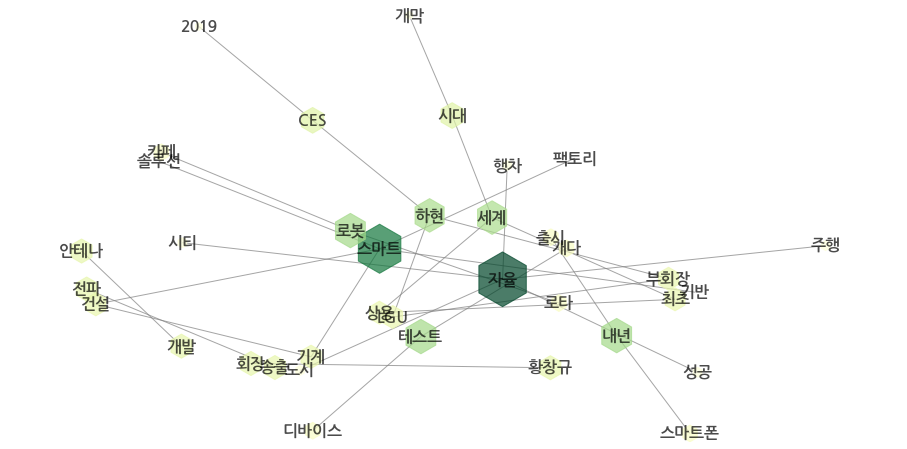

In [60]:
draw_whole_graph(df_sna)

### LDA를 통한 topic 별 SNA

앞서 구한 LDA topic별 SNA graph

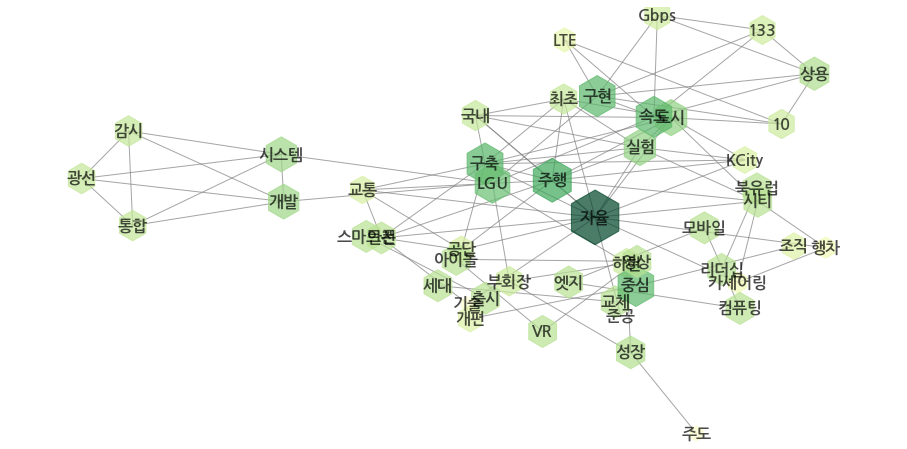

In [61]:
draw_whole_graph(optimal_keywords_support_1)

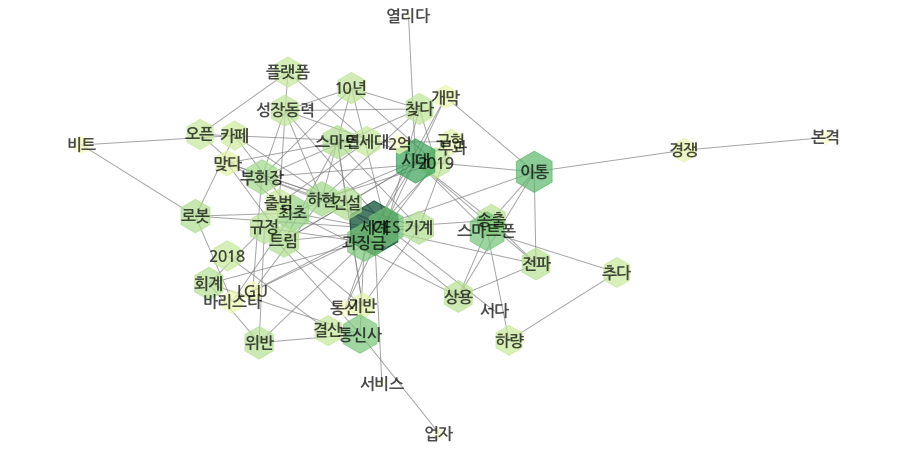

In [62]:
draw_whole_graph(optimal_keywords_support_2)

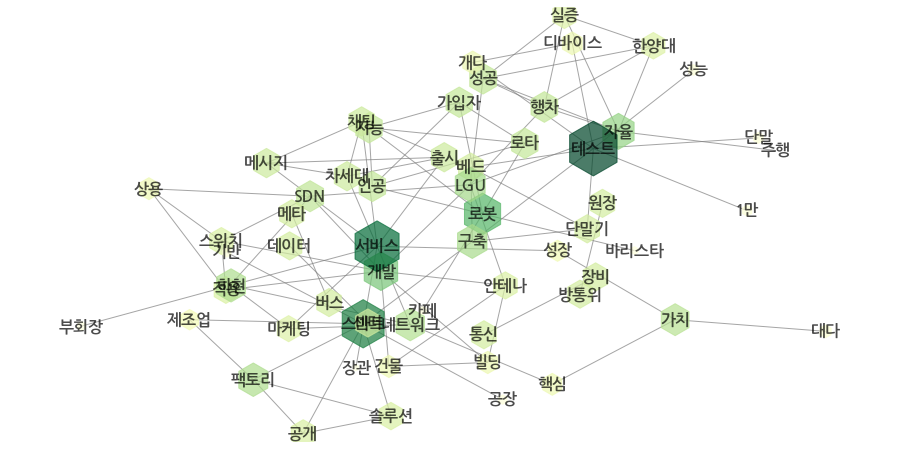

In [63]:
draw_whole_graph(optimal_keywords_support_3)

### WordCloud

In [60]:
from wordcloud import WordCloud

w = []
for sentences in clean_sent:
    noun = okt.normalize(sentences)
    noun = okt.nouns(sentences)
    noun = [word for word in noun if not word in stopwords]
    noun = [a for a in noun if len(a) > 1]
    w.append(noun)
    
ww = sum(w, [])
countww = Counter(ww)
noun_listww = countww.most_common(150)

In [61]:
def draw_wordcloud(noun_list):
    # pont_path에 자신의 font 경로 삽입
    wc = WordCloud(font_path='NanumBarunGothic.ttf',
                   background_color="white", max_font_size=60)
    cloud = wc.generate_from_frequencies(dict(noun_list))

    plt.figure(figsize=(10, 8))
    plt.axis('off')
    plt.imshow(cloud)
    plt.show()

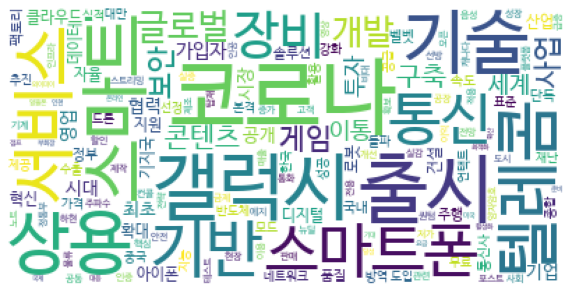

In [62]:
draw_wordcloud(noun_listww)